# Session 13: Autoencoders

### Introduction

Basic idea is that we take an image as an input, encode it to get a low dimensional embedding of the image, then decode it and reconstruct the original image as good as possible.

One possible application is video and image compression. 
- Send images over a network. Only send the encoded data. The other side has the decoder and can decode the image

For both encoding and decoding, we use a Convoutional Neural Net. This is called a **generative model** because we ultimately want to generate an image. Minimize the loss (MSE). Can think of this as a circular operation. For CNNs, we have a forward and backward movement. For each transformation we apply to the encoder, we want to apply the inverse transformation to the decoder. (Transpose)




In [1]:
!pip install torch

  Using cached torch-1.11.0-cp39-none-macosx_10_9_x86_64.whl (129.9 MB)
You should consider upgrading via the '/Users/Ivan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install torchvision

  Using cached torchvision-0.12.0-cp39-cp39-macosx_10_9_x86_64.whl (1.2 MB)
You should consider upgrading via the '/Users/Ivan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [12]:
transform = transforms.ToTensor()

# ToTensor transforms images to pytorch tensor
mnist_data = datasets.MNIST(root = './data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size = 64,
                                         shuffle=True)

In [13]:
# First batch
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


Simple feedforward NN with linear layers and a few hidden layers. We want to repeatedly reduce the size

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        # N, 784 (28x28 image size, batch size)
        super().__init__()
        self.encoder = nn.Sequential(
        # Will reduce the size from 784 to 128
        nn.Linear(28*28, 128),  # Apply linear layer. Input and output sizes
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3),  # final output size is 3 pixels
        )
    
        self.decoder = nn.Sequential(  
        # We now go in the opposite direction
        nn.Linear(3, 12),  # Apply linear layer. Input and output sizes
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),  # final output size is 784 pixels
        # We need an activation function that gives outputs between 0 and 1
        nn.Sigmoid()
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note: [-1, 1] -> nn.Tanh need to know the ranges of the data in this case
    
    
    

In [18]:
model = Autoencoder()
criterion = nn.MSELoss()  # MSE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [19]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0464
Epoch:2, Loss:0.0404
Epoch:3, Loss:0.0394
Epoch:4, Loss:0.0397
Epoch:5, Loss:0.0366
Epoch:6, Loss:0.0358
Epoch:7, Loss:0.0386
Epoch:8, Loss:0.0402
Epoch:9, Loss:0.0424
Epoch:10, Loss:0.0368


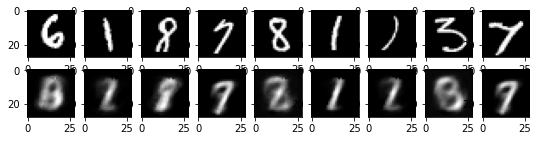

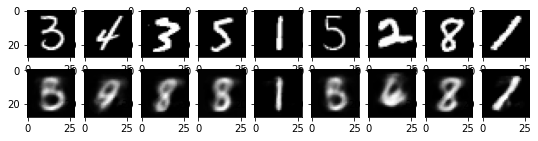

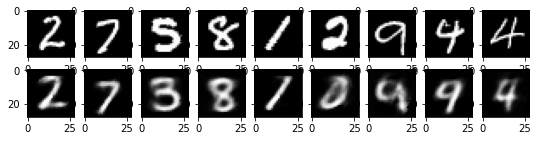

In [22]:
for k in range(0, num_epochs, 4):  # print images every fourth epoch
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28)
        # item: 1, 28, 28
        plt.imshow(item[0])

#### Using a CNN to do the same thing!

In [24]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # Input channel, Output, kernel
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [25]:
CNN_model = Autoencoder_CNN()

CNN_criterion = nn.MSELoss()
CNN_optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)



Here we have a similar training loop

In [28]:
CNN_num_epochs = 5
CNN_outputs = []
for CNN_epoch in range(CNN_num_epochs):
    for (CNN_img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        CNN_recon = CNN_model(CNN_img)
        CNN_loss = CNN_criterion(CNN_recon, CNN_img)
        
        CNN_optimizer.zero_grad()
        CNN_loss.backward()
        CNN_optimizer.step()

    print(f'Epoch:{CNN_epoch+1}, Loss:{CNN_loss.item():.4f}')
    CNN_outputs.append((CNN_epoch, CNN_img, CNN_recon))

Epoch:1, Loss:0.2361
Epoch:2, Loss:0.2354
Epoch:3, Loss:0.2354
Epoch:4, Loss:0.2358
Epoch:5, Loss:0.2349


In [1]:
for k in range(0, CNN_num_epochs, 1):
    plt.figure(figsize=(9, 2))
    plt.gray()
    CNN_imgs = outputs[k][1].detach().numpy()
    CNN_recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(CNN_imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(CNN_recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])



NameError: name 'CNN_num_epochs' is not defined

### Problem 1: Main idea of an Autoencoder

Main idea is that it is trained to attempt to copy its input to its output.

Essentially you have two portions. One is the encoding portion, which can reduce the size of some input. The next is the decoding portion, which translated the shortened text into the original input. Possible applications include image/video compression. Traditional applications include dimensionality reduction or feature learning.

**Recirculation**: NN is not trained through backprop, but rather by comparing the difference to an input vector after it is recirculatd through the network

### Problem 2: Examples of different types of Autoencoders

- **Undercomplete Autoencoder**: Autoencoder whose code dimension is less than the input dimension.
